# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *
import zarr
from fastai.callback.tracker import EarlyStoppingCallback


In [4]:
#chck if GPU is available
torch.cuda.device(0)
torch.cuda.is_available()

True

In [5]:
data_root = 'D:/OAPMLData/'

ml_path = data_root + '/4.MLData/'
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'ca_co_day1above_3h_84d_allvars_small'
#file_label = 'ca_co_day1above_3h_14d_importantvars'

In [6]:
X = zarr.open(ml_path + 'X_' + file_label + '.zarr', mode='r')

In [7]:
X.shape

(48000, 774, 673)

In [24]:
utils = TSAIUtilities(X, label)


In [9]:
feature_names = pd.read_csv(ml_path + '/FeatureLabels_' + file_label + '.csv')
feature_names = feature_names['0'].sort_values().values

In [10]:
feature_names

array(['ABSV_1000mb_avg', 'ABSV_1000mb_max', 'ABSV_1000mb_min',
       'ABSV_100mb_avg', 'ABSV_100mb_max', 'ABSV_100mb_min',
       'ABSV_10mb_avg', 'ABSV_10mb_max', 'ABSV_10mb_min',
       'ABSV_150mb_avg', 'ABSV_150mb_max', 'ABSV_150mb_min',
       'ABSV_200mb_avg', 'ABSV_200mb_max', 'ABSV_200mb_min',
       'ABSV_20mb_avg', 'ABSV_20mb_max', 'ABSV_20mb_min',
       'ABSV_250mb_avg', 'ABSV_250mb_max', 'ABSV_250mb_min',
       'ABSV_300mb_avg', 'ABSV_300mb_max', 'ABSV_300mb_min',
       'ABSV_30mb_avg', 'ABSV_30mb_max', 'ABSV_30mb_min',
       'ABSV_350mb_avg', 'ABSV_350mb_max', 'ABSV_350mb_min',
       'ABSV_400mb_avg', 'ABSV_400mb_max', 'ABSV_400mb_min',
       'ABSV_450mb_avg', 'ABSV_450mb_max', 'ABSV_450mb_min',
       'ABSV_500mb_avg', 'ABSV_500mb_max', 'ABSV_500mb_min',
       'ABSV_50mb_avg', 'ABSV_50mb_max', 'ABSV_50mb_min',
       'ABSV_550mb_avg', 'ABSV_550mb_max', 'ABSV_550mb_min',
       'ABSV_600mb_avg', 'ABSV_600mb_max', 'ABSV_600mb_min',
       'ABSV_650mb_avg', 'ABSV_65

In [11]:
num_train_files = 20 
file_list = []
for i in range(num_train_files):
    file_list.append(pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet'))

    
num_test_files = 4 
for i in range(num_test_files):
    file_list.append(pd.read_parquet(ml_path + '/y_test_batch_' + str(i + num_train_files) + '_' + file_label + '.parquet'))
    
y_df = pd.concat(file_list).reset_index(drop=True)

In [12]:
y_df['Day1DangerAboveTreeline'].value_counts()

Day1DangerAboveTreeline
Moderate        12000
Considerable    12000
Low             12000
High            12000
Name: count, dtype: int64

In [13]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [14]:
train_test_seperator = len(y_df[y_df['season'] != '20-21'])

In [15]:
train_test_seperator

40000

In [16]:
splits = (L(range(0,train_test_seperator)).shuffle(), L(range(train_test_seperator,len(y_df))).shuffle())

In [16]:
%load_ext line_profiler

In [21]:
type(X)

zarr.core.Array

In [16]:
feature_mins, feature_maxs = utils.calc_min_max(X, 0, 400000, num_to_process=50)
#%lprun -f utils.calc_min_max feature_mins, feature_maxs = utils.calc_min_max(X, 0, 10000, num_to_process=100)

on 0
on 50
on 100
on 150
on 200
on 250
on 300
on 350
on 400
on 450
on 500
on 550


In [28]:
#save feature_mins and feature_maxes to disk
np.save(ml_path + 'feature_mins_' + file_label + '.npy', feature_mins)
np.save(ml_path + 'feature_maxs_' + file_label + '.npy', feature_maxs)

In [17]:
#read feature_mins and feature_maxes from disk
feature_mins = np.load(ml_path + 'feature_mins_' + file_label + '.npy')
feature_maxs = np.load(ml_path + 'feature_maxs_' + file_label + '.npy')


In [18]:
lr = 1e-5

In [19]:
X.shape

(48000, 774, 673)

In [20]:
days = 14
X14 = X[:,:,-1*days*8:]

In [21]:
X14.shape

(48000, 774, 112)

In [27]:
_, dls_14 = utils.create_dls(X14, y, feature_mins=np.array(feature_mins), feature_maxs=np.array(feature_maxs), sample_frac=1.0, splits=splits, batch_size=96)


In [28]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=-1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis, weight=torch.tensor([1.0, 1.5, 1.5, 1.0]).to('cuda:0'))
        #self.label_smoothing = LabelSmoothingCrossEntropyFlat(weight=torch.tensor([1.0, 1.5, 1.5, 1.0]).to('cuda:0'))
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
        #return self.focal_loss(pred, targ) + self.alpha * self.label_smoothing(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [29]:
model_14 = TSTPlus(dls_14.vars, dls_14.c, seq_len=days*8, d_model=15, n_heads=15, d_k=1, d_v=2, d_ff=128, dropout=.2, n_layers=8, fc_dropout=.8, attn_dropout=.4, store_attn=False)
#learn_14 = Learner(dls_14, model_14, loss_func=LabelSmoothingCrossEntropy(weight=torch.tensor([1.0, 10.0, 10.0, 1.0]).to('cuda:0')), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[ShowGraphCallback2(), PredictionDynamics()])
#.58 learn_14 = Learner(dls_14, model_14, loss_func=DiceLoss(), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[ShowGraphCallback2(), PredictionDynamics()])
#.592 learn_14 = Learner(dls_14, model_14, loss_func=FocalLoss(), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[ShowGraphCallback2(), PredictionDynamics()])
#601 with no weights learn_14 = Learner(dls_14, model_14, loss_func=CombinedLoss(), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[ShowGraphCallback2(), PredictionDynamics()])
#.605 with 1.5 weights
#.605 with 1.4 weights
learn_14 = Learner(dls_14, model_14, loss_func=CombinedLoss(), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[ShowGraphCallback2(), PredictionDynamics()])

In [30]:
learn_14.fit_one_cycle(100, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=10)])
interp = ClassificationInterpretation.from_learner(learn_14)
conf_matrix = interp.plot_confusion_matrix(normalize=True)
#fi = learn_14.feature_importance(feature_names=list(feature_names))

In [23]:
days=14
_, dls_14 = utils.create_dls(X, y, feature_mins=np.array(feature_mins), feature_maxs=np.array(feature_maxs), sample_frac=.1, splits=splits, batch_size=64)

Splits order will change since sample_frac < 1


In [20]:
X.shape

(480000, 551, 113)

In [21]:
model_14 = TSTPlus(dls_14.vars, dls_14.c, seq_len=X.shape[2], d_model=40, n_heads=40, d_k=1, d_v=2, d_ff=128, dropout=.3, n_layers=22, fc_dropout=.8, attn_dropout=.4, store_attn=False)
#54% with 5.0 weight on class 1 and 2
#~58% wiht 2.0 weight on class 1 and 2
#55% with 3.0 weight on class 1 and 2
learn_14 = Learner(dls_14, model_14, loss_func=DiceLoss(weight=torch.tensor([1.0, 2.0, 2.0, 1.0]).to('cuda:0')), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[ShowGraphCallback2(), PredictionDynamics()])

In [ ]:
#try changing the loss function to DiceLoss, FocalLoss and CombinedLoss (labelsmoothing + focalloss)

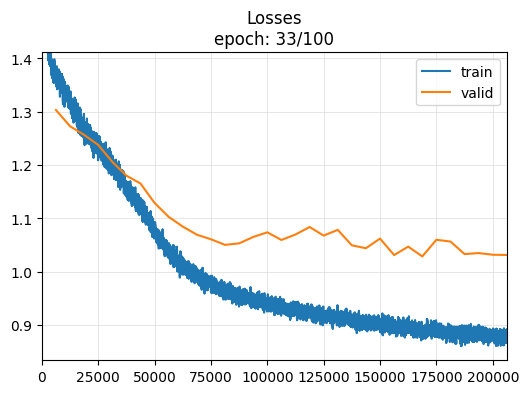

train_loss  valid_loss  accuracy  balanced_accuracy_score
32     0.88243     1.03139  0.485988                  0.47631

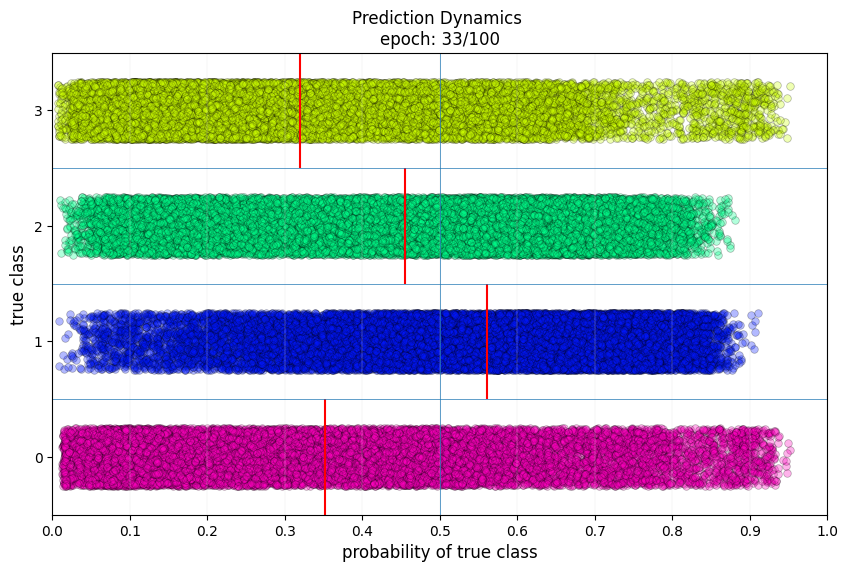

No improvement since epoch 18: early stopping


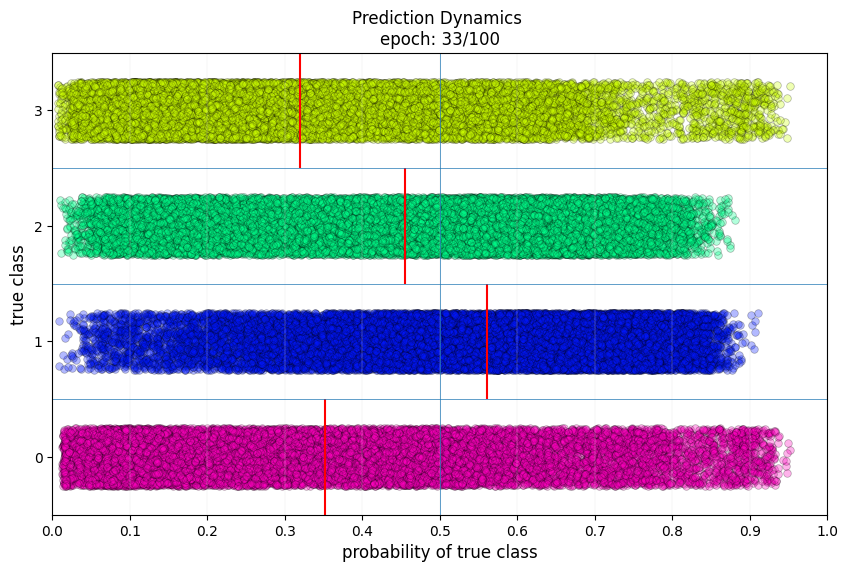

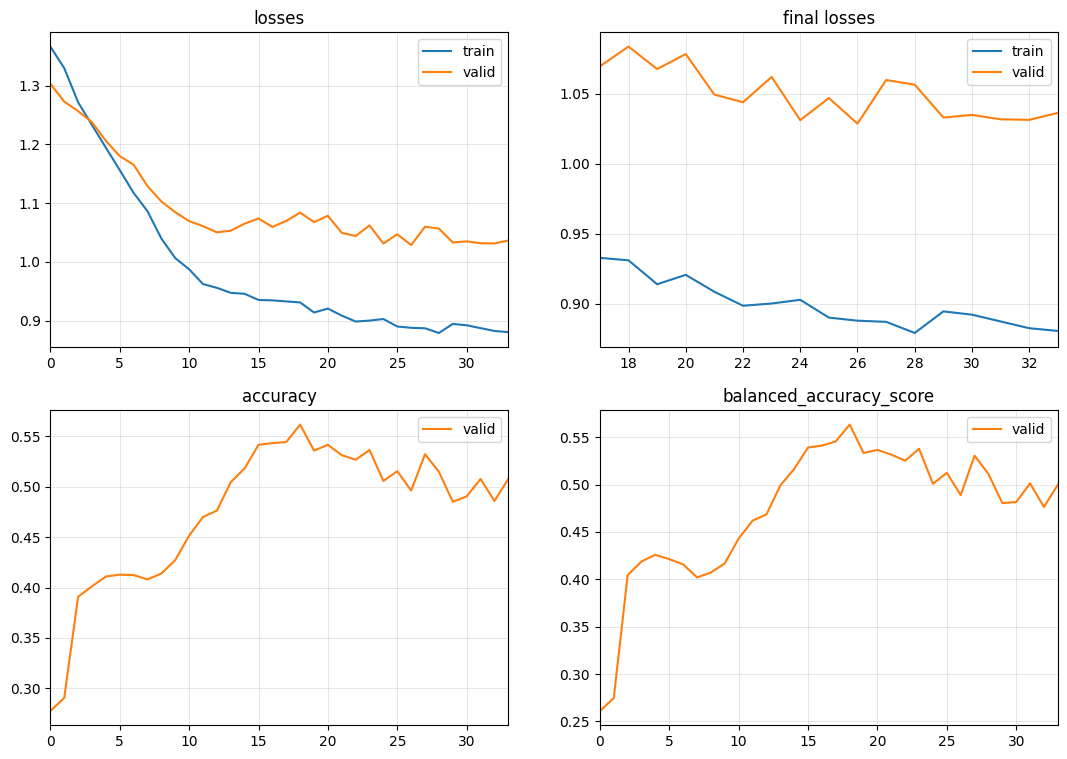

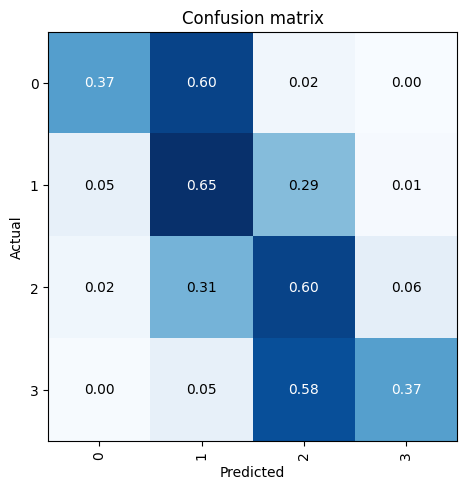

In [22]:
#bigger mode, 1, 4, 4, 1 weights
learn_14.fit_one_cycle(100, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=15)])
interp = ClassificationInterpretation.from_learner(learn_14)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

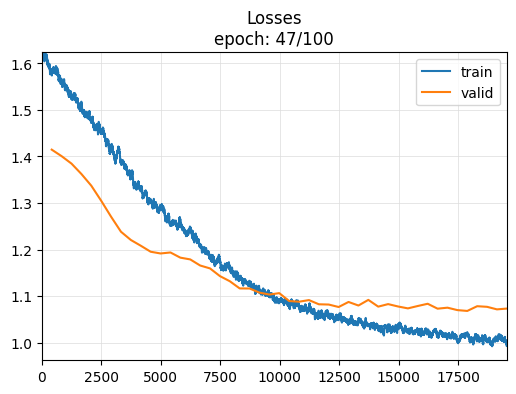

train_loss  valid_loss  accuracy  balanced_accuracy_score
46    0.994076    1.073209  0.547375                 0.547375

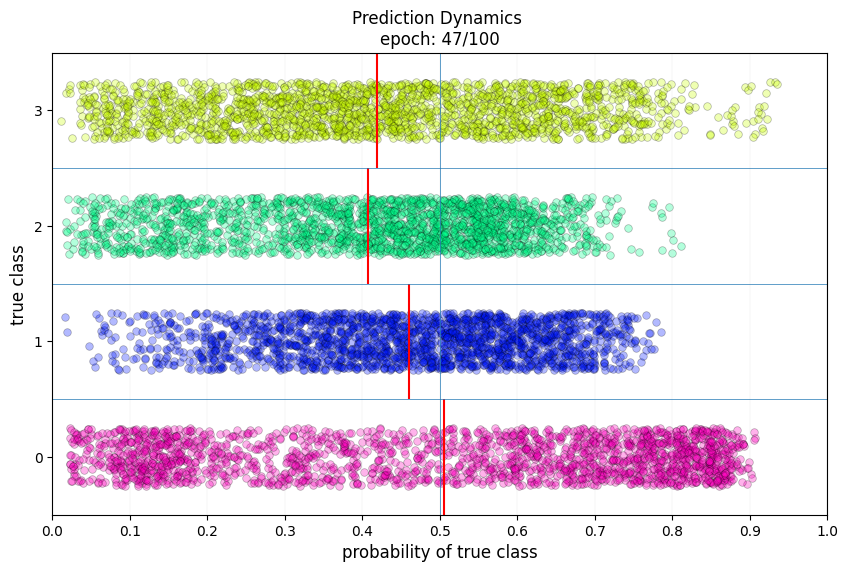

No improvement since epoch 32: early stopping


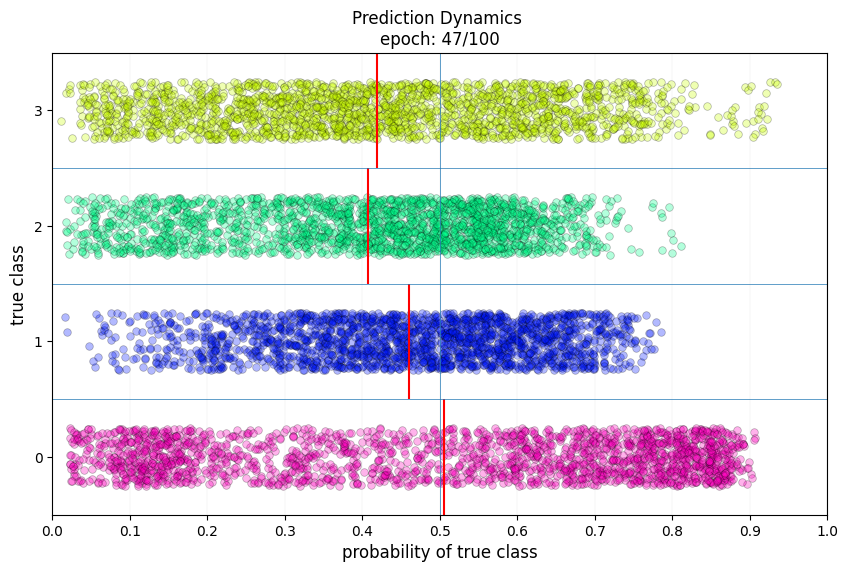

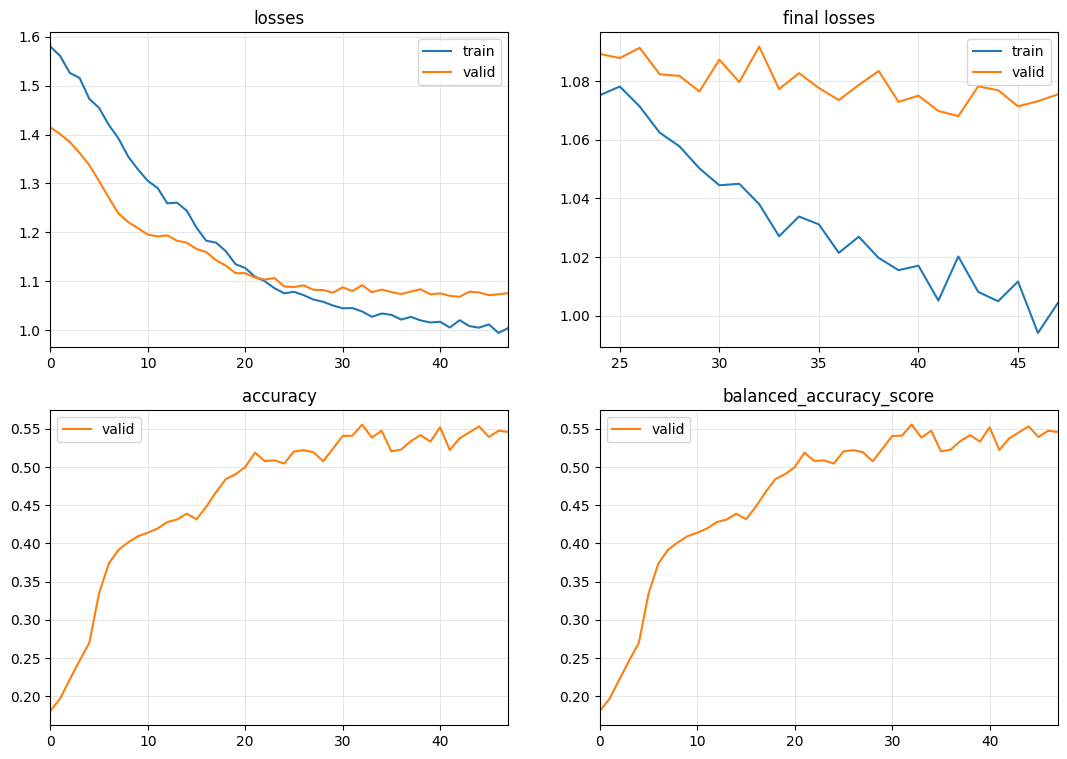

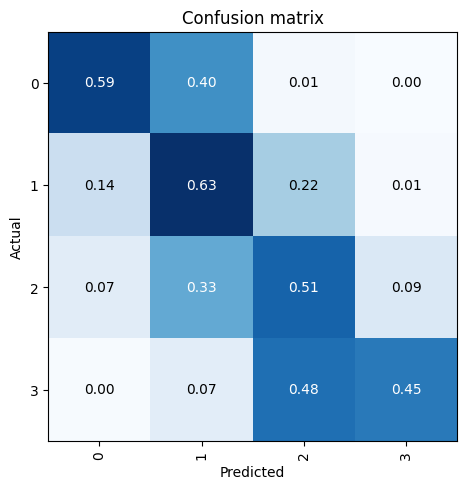

In [20]:
learn_14.fit_one_cycle(100, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=15)])
interp = ClassificationInterpretation.from_learner(learn_14)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

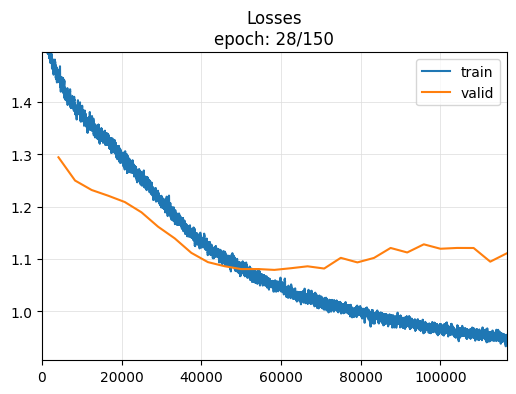

train_loss  valid_loss  accuracy  balanced_accuracy_score
27    0.943944    1.111081   0.56365                 0.565803

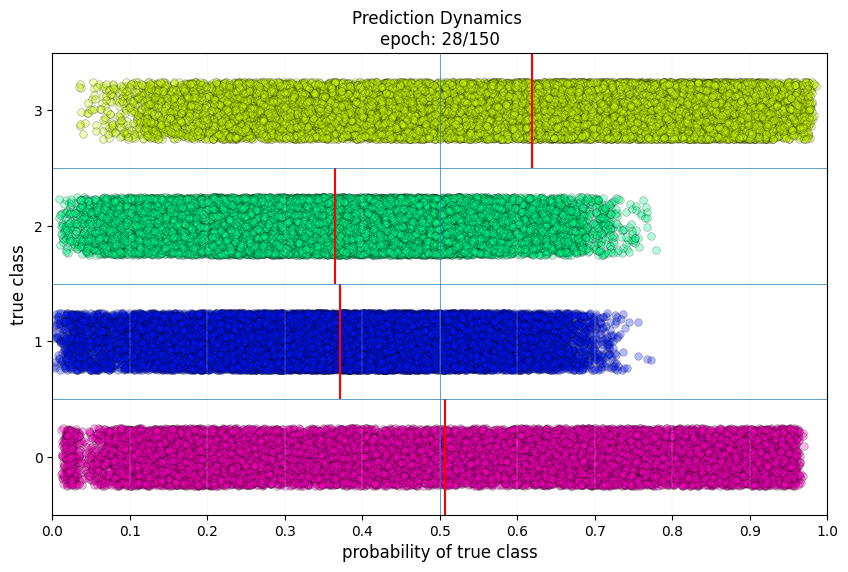

No improvement since epoch 23: early stopping


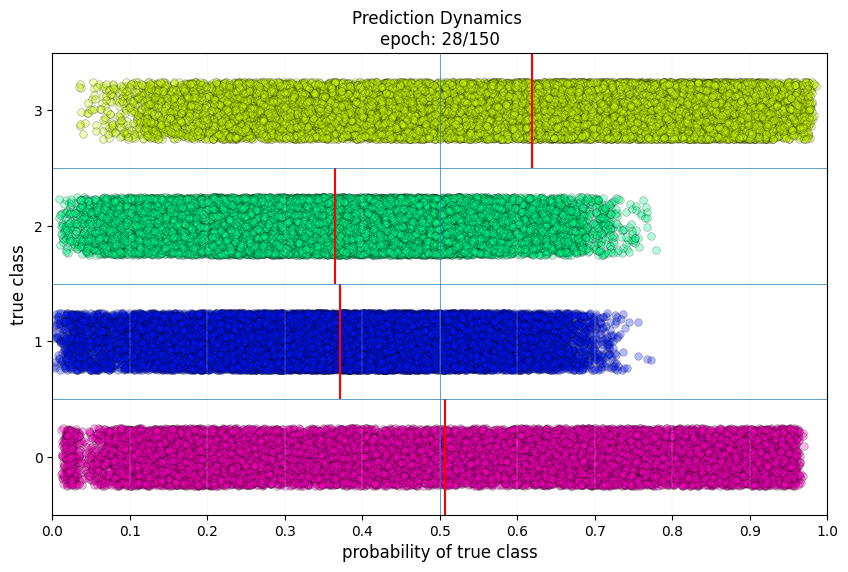

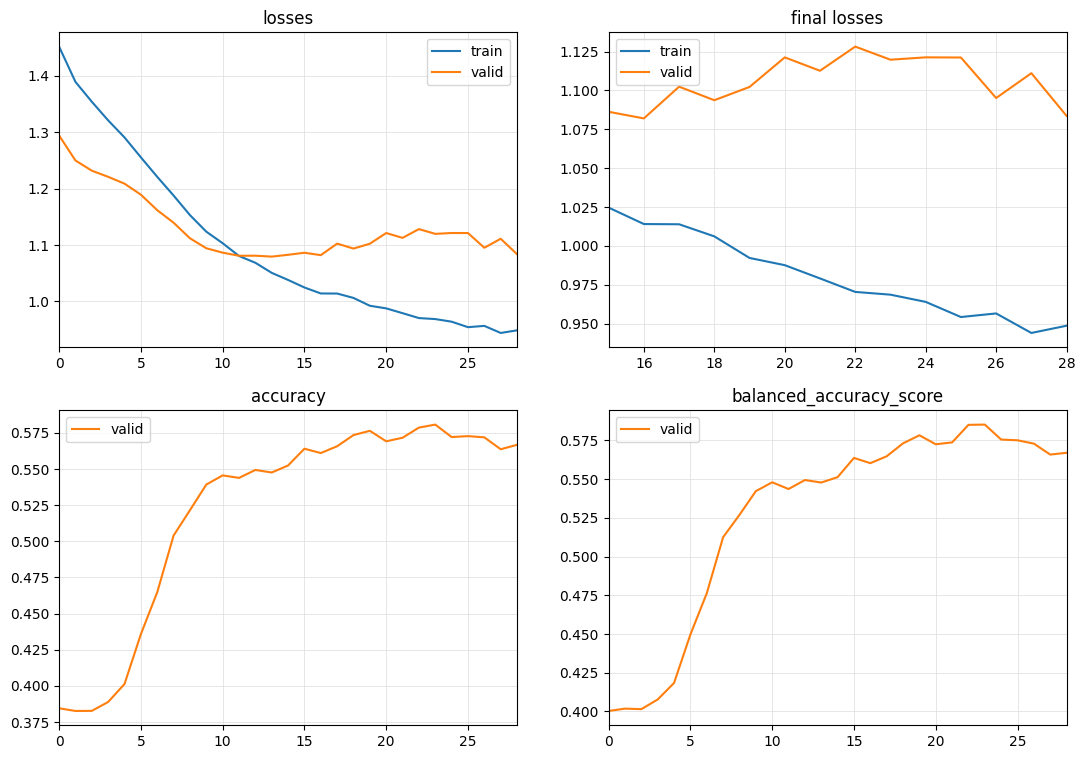

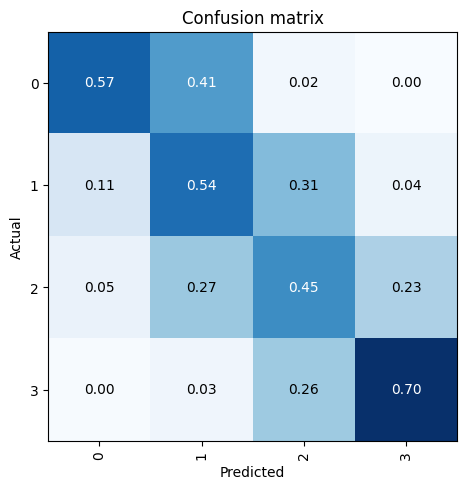

In [40]:
#full dataset
learn_14.fit_one_cycle(150, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=5)])
interp = ClassificationInterpretation.from_learner(learn_14)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

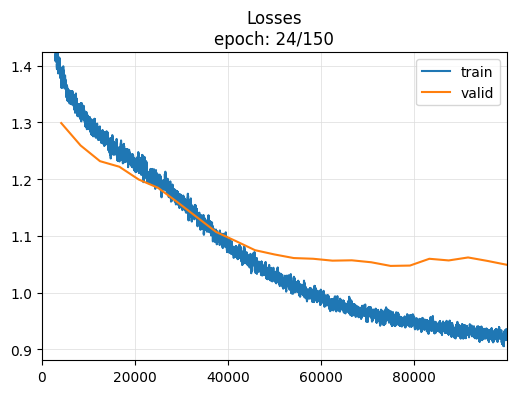

train_loss  valid_loss  accuracy  balanced_accuracy_score
23    0.932053    1.049133    0.5245                 0.522238

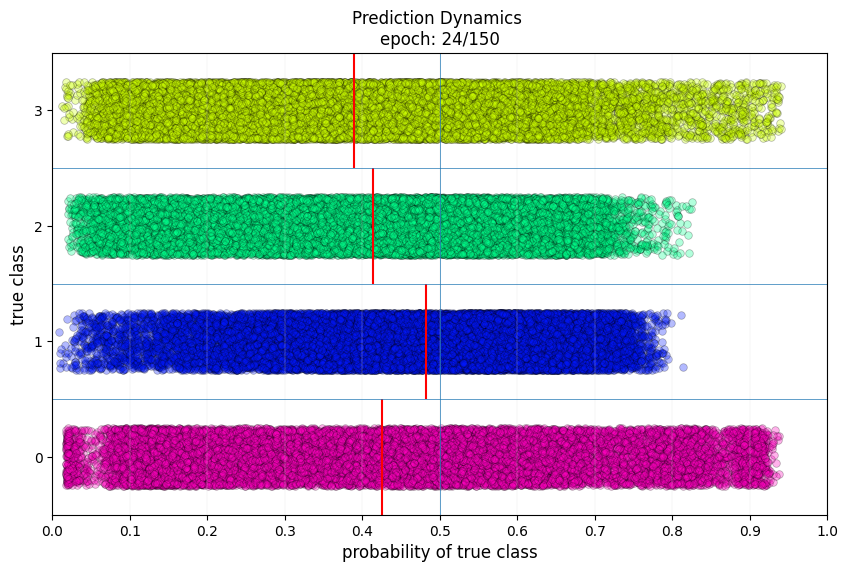

No improvement since epoch 19: early stopping


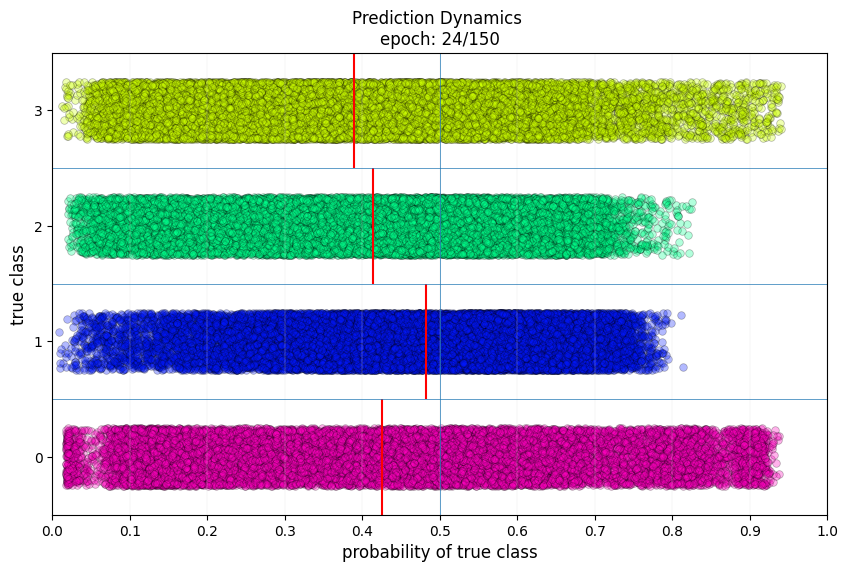

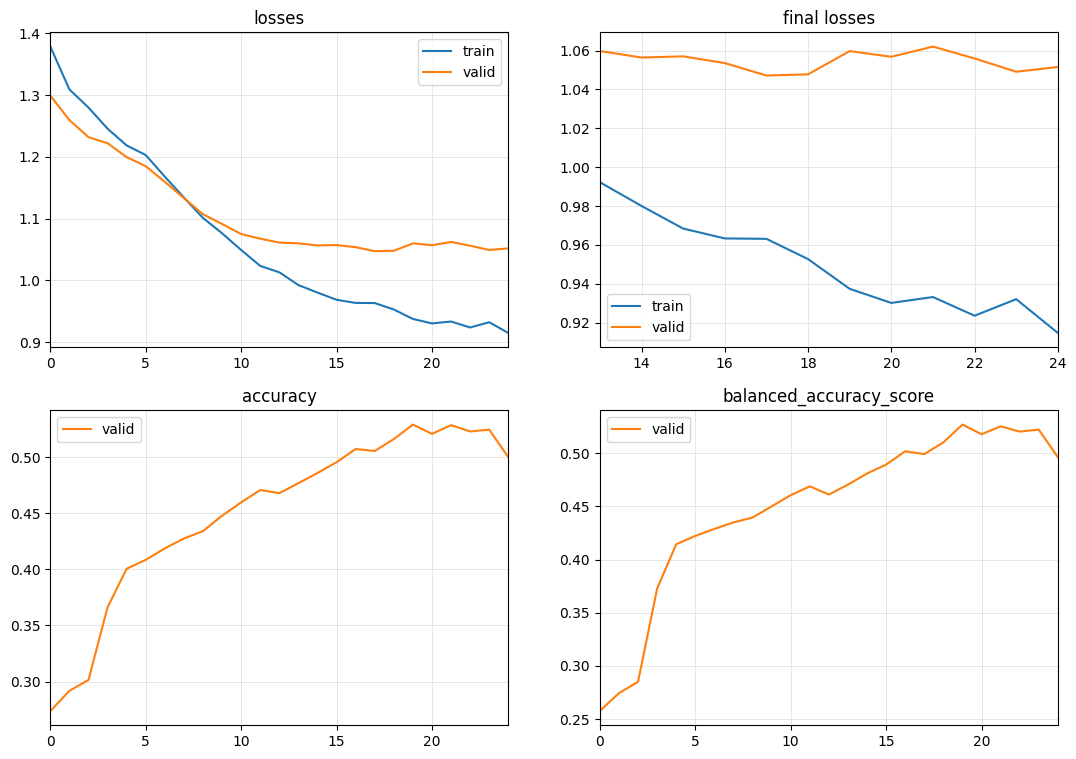

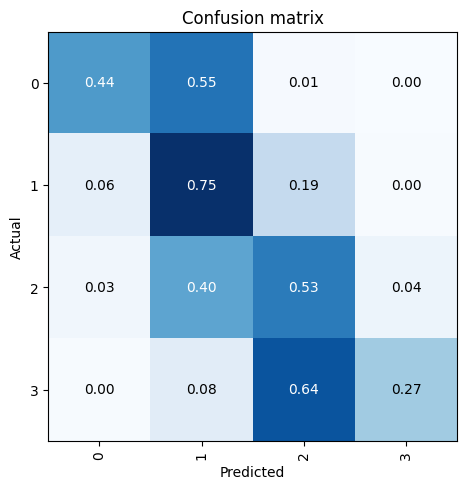

In [21]:
#full dataset weight 1.0, 4.0, 4.0, 1.0
learn_14.fit_one_cycle(150, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=5)])
interp = ClassificationInterpretation.from_learner(learn_14)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

In [24]:
#save model and feature importance
learn_14.export(ml_path + 'model_' + file_label + '_14days')
fi.to_csv(ml_path + 'fi_' + file_label + '_14days.csv')

In [25]:
del model_14, learn_14, dls_14 

### Results


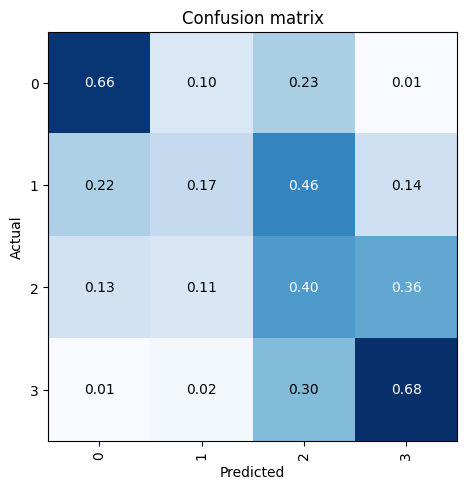

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

X.shape: (40000, 774, 112)
y.shape: (40000,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.585100


  0 feature: ABSV_1000mb_avg      accuracy: 0.585225


  1 feature: ABSV_1000mb_max      accuracy: 0.585175


  2 feature: ABSV_1000mb_min      accuracy: 0.585350


  3 feature: ABSV_100mb_avg       accuracy: 0.585025


  4 feature: ABSV_100mb_max       accuracy: 0.585100


  5 feature: ABSV_100mb_min       accuracy: 0.585075


  6 feature: ABSV_10mb_avg        accuracy: 0.584975


  7 feature: ABSV_10mb_max        accuracy: 0.584800


  8 feature: ABSV_10mb_min        accuracy: 0.585200


  9 feature: ABSV_150mb_avg       accuracy: 0.585200


 10 feature: ABSV_150mb_max       accuracy: 0.585100


 11 feature: ABSV_150mb_min       accuracy: 0.585125


 12 feature: ABSV_200mb_avg       accuracy: 0.585150


 13 feature: ABSV_200mb_max       accuracy: 0.585075


 14 feature: ABSV_200mb_min       accuracy: 0.584675


 15 feature: ABSV_20mb_avg        accuracy: 0.584975


 16 feature: ABSV_20mb_max        accuracy: 0.585025


 17 feature: ABSV_20mb_min        accuracy: 0.585025


 18 feature: ABSV_250mb_avg       accuracy: 0.584675


 19 feature: ABSV_250mb_max       accuracy: 0.585050


 20 feature: ABSV_250mb_min       accuracy: 0.584600


 21 feature: ABSV_300mb_avg       accuracy: 0.584775


 22 feature: ABSV_300mb_max       accuracy: 0.584550


 23 feature: ABSV_300mb_min       accuracy: 0.584700


 24 feature: ABSV_30mb_avg        accuracy: 0.585125


 25 feature: ABSV_30mb_max        accuracy: 0.585000


 26 feature: ABSV_30mb_min        accuracy: 0.585000


 27 feature: ABSV_350mb_avg       accuracy: 0.584550


 28 feature: ABSV_350mb_max       accuracy: 0.585075


 29 feature: ABSV_350mb_min       accuracy: 0.584800


 30 feature: ABSV_400mb_avg       accuracy: 0.585150


 31 feature: ABSV_400mb_max       accuracy: 0.585050


 32 feature: ABSV_400mb_min       accuracy: 0.584875


 33 feature: ABSV_450mb_avg       accuracy: 0.585000


 34 feature: ABSV_450mb_max       accuracy: 0.584950


 35 feature: ABSV_450mb_min       accuracy: 0.585125


 36 feature: ABSV_500mb_avg       accuracy: 0.585200


 37 feature: ABSV_500mb_max       accuracy: 0.584900


 38 feature: ABSV_500mb_min       accuracy: 0.585250


 39 feature: ABSV_50mb_avg        accuracy: 0.584975


 40 feature: ABSV_50mb_max        accuracy: 0.584925


 41 feature: ABSV_50mb_min        accuracy: 0.584875


 42 feature: ABSV_550mb_avg       accuracy: 0.585100


 43 feature: ABSV_550mb_max       accuracy: 0.584925


 44 feature: ABSV_550mb_min       accuracy: 0.585000


 45 feature: ABSV_600mb_avg       accuracy: 0.585200


 46 feature: ABSV_600mb_max       accuracy: 0.584800


 47 feature: ABSV_600mb_min       accuracy: 0.585100


 48 feature: ABSV_650mb_avg       accuracy: 0.585200


 49 feature: ABSV_650mb_max       accuracy: 0.584950


 50 feature: ABSV_650mb_min       accuracy: 0.585100


 51 feature: ABSV_700mb_avg       accuracy: 0.584350


 52 feature: ABSV_700mb_max       accuracy: 0.585200


 53 feature: ABSV_700mb_min       accuracy: 0.584725


 54 feature: ABSV_70mb_avg        accuracy: 0.585000


 55 feature: ABSV_70mb_max        accuracy: 0.585050


 56 feature: ABSV_70mb_min        accuracy: 0.585075


 57 feature: ABSV_750mb_avg       accuracy: 0.584925


 58 feature: ABSV_750mb_max       accuracy: 0.585200


 59 feature: ABSV_750mb_min       accuracy: 0.585200


 60 feature: ABSV_800mb_avg       accuracy: 0.584925


 61 feature: ABSV_800mb_max       accuracy: 0.584900


 62 feature: ABSV_800mb_min       accuracy: 0.584875


 63 feature: ABSV_850mb_avg       accuracy: 0.585000


 64 feature: ABSV_850mb_max       accuracy: 0.584950


 65 feature: ABSV_850mb_min       accuracy: 0.584675


 66 feature: ABSV_900mb_avg       accuracy: 0.584925


 67 feature: ABSV_900mb_max       accuracy: 0.585000


 68 feature: ABSV_900mb_min       accuracy: 0.585200


 69 feature: ABSV_925mb_avg       accuracy: 0.585100


 70 feature: ABSV_925mb_max       accuracy: 0.585050


 71 feature: ABSV_925mb_min       accuracy: 0.585225


 72 feature: ABSV_950mb_avg       accuracy: 0.585050


 73 feature: ABSV_950mb_max       accuracy: 0.585075


 74 feature: ABSV_950mb_min       accuracy: 0.585250


 75 feature: ABSV_975mb_avg       accuracy: 0.585175


 76 feature: ABSV_975mb_max       accuracy: 0.585175


 77 feature: ABSV_975mb_min       accuracy: 0.585000


 78 feature: ACPCP_surface_sum    accuracy: 0.584825


 79 feature: APCP_surface_sum     accuracy: 0.582350


 80 feature: APTMP_2maboveground_avg accuracy: 0.585175


 81 feature: APTMP_2maboveground_max accuracy: 0.584775


 82 feature: APTMP_2maboveground_min accuracy: 0.585300


 83 feature: CAPE_180M0mbaboveground_avg accuracy: 0.584825


 84 feature: CAPE_180M0mbaboveground_max accuracy: 0.584875


 85 feature: CAPE_180M0mbaboveground_min accuracy: 0.584975


 86 feature: CAPE_255M0mbaboveground_avg accuracy: 0.584850


 87 feature: CAPE_255M0mbaboveground_max accuracy: 0.584850


 88 feature: CAPE_255M0mbaboveground_min accuracy: 0.584850


 89 feature: CAPE_surface_avg     accuracy: 0.584900


 90 feature: CAPE_surface_max     accuracy: 0.585000


 91 feature: CAPE_surface_min     accuracy: 0.585100


 92 feature: CIN_180M0mbaboveground_avg accuracy: 0.584900


 93 feature: CIN_180M0mbaboveground_max accuracy: 0.585100


 94 feature: CIN_180M0mbaboveground_min accuracy: 0.584750


 95 feature: CIN_255M0mbaboveground_avg accuracy: 0.584950


 96 feature: CIN_255M0mbaboveground_max accuracy: 0.585125


 97 feature: CIN_255M0mbaboveground_min accuracy: 0.584975


 98 feature: CIN_surface_avg      accuracy: 0.585225


 99 feature: CIN_surface_max      accuracy: 0.584900


100 feature: CIN_surface_min      accuracy: 0.584975


101 feature: CPOFP_surface_avg    accuracy: 0.584175


102 feature: CPOFP_surface_max    accuracy: 0.583475


103 feature: CPOFP_surface_min    accuracy: 0.577775


104 feature: DPT_2maboveground_avg accuracy: 0.585000


105 feature: DPT_2maboveground_max accuracy: 0.584900


106 feature: DPT_2maboveground_min accuracy: 0.584975


107 feature: GUST_surface_avg     accuracy: 0.582400


108 feature: GUST_surface_max     accuracy: 0.580475


109 feature: GUST_surface_min     accuracy: 0.581075


110 feature: HGT_0Cisotherm_avg   accuracy: 0.584725


111 feature: HGT_0Cisotherm_max   accuracy: 0.582100


112 feature: HGT_0Cisotherm_min   accuracy: 0.578825


113 feature: HGT_1000mb_avg       accuracy: 0.586525


114 feature: HGT_1000mb_max       accuracy: 0.580475


115 feature: HGT_1000mb_min       accuracy: 0.582275


116 feature: HGT_100mb_avg        accuracy: 0.584950


117 feature: HGT_100mb_max        accuracy: 0.584800


118 feature: HGT_100mb_min        accuracy: 0.585025


119 feature: HGT_10mb_avg         accuracy: 0.585025


120 feature: HGT_10mb_max         accuracy: 0.585100


121 feature: HGT_10mb_min         accuracy: 0.584625


122 feature: HGT_150mb_avg        accuracy: 0.584525


123 feature: HGT_150mb_max        accuracy: 0.584975


124 feature: HGT_150mb_min        accuracy: 0.584925


125 feature: HGT_200mb_avg        accuracy: 0.585300


126 feature: HGT_200mb_max        accuracy: 0.584875


127 feature: HGT_200mb_min        accuracy: 0.585275


128 feature: HGT_20mb_avg         accuracy: 0.585125


129 feature: HGT_20mb_max         accuracy: 0.585125


130 feature: HGT_20mb_min         accuracy: 0.585050


131 feature: HGT_250mb_avg        accuracy: 0.584775


132 feature: HGT_250mb_max        accuracy: 0.585200


133 feature: HGT_250mb_min        accuracy: 0.584500


134 feature: HGT_300mb_avg        accuracy: 0.585050


135 feature: HGT_300mb_max        accuracy: 0.585775


136 feature: HGT_300mb_min        accuracy: 0.584725


137 feature: HGT_30mb_avg         accuracy: 0.584450


138 feature: HGT_30mb_max         accuracy: 0.585050


139 feature: HGT_30mb_min         accuracy: 0.584950


140 feature: HGT_350mb_avg        accuracy: 0.585025


141 feature: HGT_350mb_max        accuracy: 0.585725


142 feature: HGT_350mb_min        accuracy: 0.585000


143 feature: HGT_400mb_avg        accuracy: 0.585075


144 feature: HGT_400mb_max        accuracy: 0.585500


145 feature: HGT_400mb_min        accuracy: 0.584950


146 feature: HGT_450mb_avg        accuracy: 0.585200


147 feature: HGT_450mb_max        accuracy: 0.585025


148 feature: HGT_450mb_min        accuracy: 0.585075


149 feature: HGT_500mb_avg        accuracy: 0.584925


150 feature: HGT_500mb_max        accuracy: 0.585325


151 feature: HGT_500mb_min        accuracy: 0.585550


152 feature: HGT_50mb_avg         accuracy: 0.585025


153 feature: HGT_50mb_max         accuracy: 0.585100


154 feature: HGT_50mb_min         accuracy: 0.584875


155 feature: HGT_550mb_avg        accuracy: 0.584025


156 feature: HGT_550mb_max        accuracy: 0.585125


157 feature: HGT_550mb_min        accuracy: 0.584950


158 feature: HGT_600mb_avg        accuracy: 0.584250


159 feature: HGT_600mb_max        accuracy: 0.584300


160 feature: HGT_600mb_min        accuracy: 0.584275


161 feature: HGT_650mb_avg        accuracy: 0.585675


162 feature: HGT_650mb_max        accuracy: 0.585025


163 feature: HGT_650mb_min        accuracy: 0.584875


164 feature: HGT_700mb_avg        accuracy: 0.585325


165 feature: HGT_700mb_max        accuracy: 0.584800


166 feature: HGT_700mb_min        accuracy: 0.583950


167 feature: HGT_70mb_avg         accuracy: 0.585225


168 feature: HGT_70mb_max         accuracy: 0.585150


169 feature: HGT_70mb_min         accuracy: 0.584975


170 feature: HGT_750mb_avg        accuracy: 0.584250


171 feature: HGT_750mb_max        accuracy: 0.584400


172 feature: HGT_750mb_min        accuracy: 0.583675


173 feature: HGT_800mb_avg        accuracy: 0.583425


174 feature: HGT_800mb_max        accuracy: 0.585775


175 feature: HGT_800mb_min        accuracy: 0.583600


176 feature: HGT_850mb_avg        accuracy: 0.585575


177 feature: HGT_850mb_max        accuracy: 0.585475


178 feature: HGT_850mb_min        accuracy: 0.585175


179 feature: HGT_900mb_avg        accuracy: 0.582950


180 feature: HGT_900mb_max        accuracy: 0.584300


181 feature: HGT_900mb_min        accuracy: 0.585775


182 feature: HGT_925mb_avg        accuracy: 0.581150


183 feature: HGT_925mb_max        accuracy: 0.583150


184 feature: HGT_925mb_min        accuracy: 0.585100


185 feature: HGT_950mb_avg        accuracy: 0.583850


186 feature: HGT_950mb_max        accuracy: 0.584575


187 feature: HGT_950mb_min        accuracy: 0.580225


188 feature: HGT_975mb_avg        accuracy: 0.581450


189 feature: HGT_975mb_max        accuracy: 0.586250


190 feature: HGT_975mb_min        accuracy: 0.582500


191 feature: HGT_PV_EQ_2eM06_Km_2_kg_s_surface_avg accuracy: 0.583825


192 feature: HGT_PV_EQ_2eM06_Km_2_kg_s_surface_max accuracy: 0.585175


193 feature: HGT_PV_EQ_2eM06_Km_2_kg_s_surface_min accuracy: 0.583225


194 feature: HGT_maxwind_avg      accuracy: 0.584975


195 feature: HGT_maxwind_max      accuracy: 0.584750


196 feature: HGT_maxwind_min      accuracy: 0.585025


197 feature: HGT_surface_avg      accuracy: 0.582750


198 feature: HGT_surface_max      accuracy: 0.580400


199 feature: HGT_surface_min      accuracy: 0.575225


200 feature: HGT_tropopause_avg   accuracy: 0.584175


201 feature: HGT_tropopause_max   accuracy: 0.585200


202 feature: HGT_tropopause_min   accuracy: 0.586425


203 feature: HINDEX_surface_avg   accuracy: 0.584050


204 feature: HINDEX_surface_max   accuracy: 0.583875


205 feature: HINDEX_surface_min   accuracy: 0.585050


206 feature: HLCY_3000M0maboveground_avg accuracy: 0.579425


207 feature: HLCY_3000M0maboveground_max accuracy: 0.580775


208 feature: HLCY_3000M0maboveground_min accuracy: 0.579775


209 feature: ICAHT_maxwind_avg    accuracy: 0.585425


210 feature: ICAHT_maxwind_max    accuracy: 0.584075


211 feature: ICAHT_maxwind_min    accuracy: 0.584825


212 feature: ICAHT_tropopause_avg accuracy: 0.584800


213 feature: ICAHT_tropopause_max accuracy: 0.584300


214 feature: ICAHT_tropopause_min accuracy: 0.585575


215 feature: ICEC_surface_avg     accuracy: 0.585100


216 feature: ICEC_surface_max     accuracy: 0.585100


217 feature: ICEC_surface_min     accuracy: 0.585100


218 feature: LAND_surface_avg     accuracy: 0.585475


219 feature: LAND_surface_max     accuracy: 0.585100


220 feature: LAND_surface_min     accuracy: 0.587850


221 feature: POT_0D995sigmalevel_avg accuracy: 0.585200


222 feature: POT_0D995sigmalevel_max accuracy: 0.584900


223 feature: POT_0D995sigmalevel_min accuracy: 0.585250


224 feature: PRES_80maboveground_avg accuracy: 0.583575


225 feature: PRES_80maboveground_max accuracy: 0.587225


226 feature: PRES_80maboveground_min accuracy: 0.584100


227 feature: PRES_PV_EQ_2eM06_Km_2_kg_s_surface_avg accuracy: 0.585975


228 feature: PRES_PV_EQ_2eM06_Km_2_kg_s_surface_max accuracy: 0.584650


229 feature: PRES_PV_EQ_2eM06_Km_2_kg_s_surface_min accuracy: 0.585225


230 feature: PRES_maxwind_avg     accuracy: 0.586275


231 feature: PRES_maxwind_max     accuracy: 0.586625


232 feature: PRES_maxwind_min     accuracy: 0.585150


233 feature: PRES_surface_avg     accuracy: 0.586150


234 feature: PRES_surface_max     accuracy: 0.584275


235 feature: PRES_surface_min     accuracy: 0.584450


236 feature: PRES_tropopause_avg  accuracy: 0.582375


237 feature: PRES_tropopause_max  accuracy: 0.586175


238 feature: PRES_tropopause_min  accuracy: 0.585575


239 feature: PRMSL_meansealevel_avg accuracy: 0.584775


240 feature: PRMSL_meansealevel_max accuracy: 0.584825


241 feature: PRMSL_meansealevel_min accuracy: 0.585150


242 feature: RH_0Cisotherm_avg    accuracy: 0.588725


243 feature: RH_0Cisotherm_max    accuracy: 0.584625


244 feature: RH_0Cisotherm_min    accuracy: 0.582275


245 feature: RH_0D33M1sigmalayer_avg accuracy: 0.578600


246 feature: RH_0D33M1sigmalayer_max accuracy: 0.582150


247 feature: RH_0D33M1sigmalayer_min accuracy: 0.581275


248 feature: RH_0D44M0D72sigmalayer_avg accuracy: 0.579275


249 feature: RH_0D44M0D72sigmalayer_max accuracy: 0.580100


250 feature: RH_0D44M0D72sigmalayer_min accuracy: 0.600800


251 feature: RH_0D44M1sigmalayer_avg accuracy: 0.584275


252 feature: RH_0D44M1sigmalayer_max accuracy: 0.579300


253 feature: RH_0D44M1sigmalayer_min accuracy: 0.581700


254 feature: RH_0D72M0D94sigmalayer_avg accuracy: 0.580175


255 feature: RH_0D72M0D94sigmalayer_max accuracy: 0.580250


256 feature: RH_0D72M0D94sigmalayer_min accuracy: 0.587150


257 feature: RH_0D995sigmalevel_avg accuracy: 0.582100


258 feature: RH_0D995sigmalevel_max accuracy: 0.577825


259 feature: RH_0D995sigmalevel_min accuracy: 0.580700


260 feature: RH_1000mb_avg        accuracy: 0.590600


261 feature: RH_1000mb_max        accuracy: 0.588900


262 feature: RH_1000mb_min        accuracy: 0.587125


263 feature: RH_100mb_avg         accuracy: 0.585350


264 feature: RH_100mb_max         accuracy: 0.584525


265 feature: RH_100mb_min         accuracy: 0.584650


266 feature: RH_10mb_avg          accuracy: 0.584475


267 feature: RH_10mb_max          accuracy: 0.584525


268 feature: RH_10mb_min          accuracy: 0.584625


269 feature: RH_150mb_avg         accuracy: 0.584825


270 feature: RH_150mb_max         accuracy: 0.584075


271 feature: RH_150mb_min         accuracy: 0.584525


272 feature: RH_200mb_avg         accuracy: 0.585525


273 feature: RH_200mb_max         accuracy: 0.586375


274 feature: RH_200mb_min         accuracy: 0.587550


275 feature: RH_20mb_avg          accuracy: 0.584925


276 feature: RH_20mb_max          accuracy: 0.584650


277 feature: RH_20mb_min          accuracy: 0.584950


278 feature: RH_250mb_avg         accuracy: 0.584750


279 feature: RH_250mb_max         accuracy: 0.583400


280 feature: RH_250mb_min         accuracy: 0.585025


281 feature: RH_2maboveground_avg accuracy: 0.582800


282 feature: RH_2maboveground_max accuracy: 0.576200


283 feature: RH_2maboveground_min accuracy: 0.585175


284 feature: RH_300mb_avg         accuracy: 0.580400


285 feature: RH_300mb_max         accuracy: 0.585150


286 feature: RH_300mb_min         accuracy: 0.583975


287 feature: RH_30M0mbaboveground_avg accuracy: 0.587525


288 feature: RH_30M0mbaboveground_max accuracy: 0.582625


289 feature: RH_30M0mbaboveground_min accuracy: 0.595450


290 feature: RH_30mb_avg          accuracy: 0.584775


291 feature: RH_30mb_max          accuracy: 0.584725


292 feature: RH_30mb_min          accuracy: 0.584875


293 feature: RH_350mb_avg         accuracy: 0.585450


294 feature: RH_350mb_max         accuracy: 0.584475


295 feature: RH_350mb_min         accuracy: 0.589500


296 feature: RH_400mb_avg         accuracy: 0.576250


297 feature: RH_400mb_max         accuracy: 0.586375


298 feature: RH_400mb_min         accuracy: 0.584075


299 feature: RH_450mb_avg         accuracy: 0.569500


300 feature: RH_450mb_max         accuracy: 0.574675


301 feature: RH_450mb_min         accuracy: 0.589050


302 feature: RH_500mb_avg         accuracy: 0.585325


303 feature: RH_500mb_max         accuracy: 0.568625


304 feature: RH_500mb_min         accuracy: 0.568500


305 feature: RH_50mb_avg          accuracy: 0.585075


306 feature: RH_50mb_max          accuracy: 0.585125


307 feature: RH_50mb_min          accuracy: 0.585175


308 feature: RH_550mb_avg         accuracy: 0.577700


309 feature: RH_550mb_max         accuracy: 0.591250


310 feature: RH_550mb_min         accuracy: 0.588850


311 feature: RH_600mb_avg         accuracy: 0.588550


312 feature: RH_600mb_max         accuracy: 0.576400


313 feature: RH_600mb_min         accuracy: 0.589650


314 feature: RH_650mb_avg         accuracy: 0.585450


315 feature: RH_650mb_max         accuracy: 0.583250


316 feature: RH_650mb_min         accuracy: 0.588050


317 feature: RH_700mb_avg         accuracy: 0.572750


318 feature: RH_700mb_max         accuracy: 0.592775


319 feature: RH_700mb_min         accuracy: 0.578025


320 feature: RH_70mb_avg          accuracy: 0.584525


321 feature: RH_70mb_max          accuracy: 0.584350


322 feature: RH_70mb_min          accuracy: 0.584400


323 feature: RH_750mb_avg         accuracy: 0.581875


324 feature: RH_750mb_max         accuracy: 0.578200


325 feature: RH_750mb_min         accuracy: 0.583925


326 feature: RH_800mb_avg         accuracy: 0.578725


327 feature: RH_800mb_max         accuracy: 0.583875


328 feature: RH_800mb_min         accuracy: 0.573775


329 feature: RH_850mb_avg         accuracy: 0.589075


330 feature: RH_850mb_max         accuracy: 0.578800


331 feature: RH_850mb_min         accuracy: 0.581375


332 feature: RH_900mb_avg         accuracy: 0.586575


333 feature: RH_900mb_max         accuracy: 0.593350


334 feature: RH_900mb_min         accuracy: 0.578725


335 feature: RH_925mb_avg         accuracy: 0.585625


336 feature: RH_925mb_max         accuracy: 0.580225


337 feature: RH_925mb_min         accuracy: 0.585400


338 feature: RH_950mb_avg         accuracy: 0.580600


339 feature: RH_950mb_max         accuracy: 0.587825


340 feature: RH_950mb_min         accuracy: 0.585150


341 feature: RH_975mb_avg         accuracy: 0.580275


342 feature: RH_975mb_max         accuracy: 0.586650


343 feature: RH_975mb_min         accuracy: 0.589800


344 feature: SNOD_surface_avg     accuracy: 0.584475


345 feature: SNOD_surface_max     accuracy: 0.585675


346 feature: SNOD_surface_min     accuracy: 0.585375


347 feature: SPFH_2maboveground_avg accuracy: 0.584775


348 feature: SPFH_2maboveground_max accuracy: 0.586150


349 feature: SPFH_2maboveground_min accuracy: 0.585350


350 feature: SPFH_30M0mbaboveground_avg accuracy: 0.586925


351 feature: SPFH_30M0mbaboveground_max accuracy: 0.586850


352 feature: SPFH_30M0mbaboveground_min accuracy: 0.583975


353 feature: SPFH_80maboveground_avg accuracy: 0.584325


354 feature: SPFH_80maboveground_max accuracy: 0.584725


355 feature: SPFH_80maboveground_min accuracy: 0.586325


356 feature: TMP_0D995sigmalevel_avg accuracy: 0.585125


357 feature: TMP_0D995sigmalevel_max accuracy: 0.584975


358 feature: TMP_0D995sigmalevel_min accuracy: 0.584975


359 feature: TMP_1000mb_avg       accuracy: 0.584925


360 feature: TMP_1000mb_max       accuracy: 0.584800


361 feature: TMP_1000mb_min       accuracy: 0.584725


362 feature: TMP_100maboveground_avg accuracy: 0.584875


363 feature: TMP_100maboveground_max accuracy: 0.584725


364 feature: TMP_100maboveground_min accuracy: 0.585125


365 feature: TMP_100mb_avg        accuracy: 0.584675


366 feature: TMP_100mb_max        accuracy: 0.585150


367 feature: TMP_100mb_min        accuracy: 0.585375


368 feature: TMP_10mb_avg         accuracy: 0.584975


369 feature: TMP_10mb_max         accuracy: 0.583900


370 feature: TMP_10mb_min         accuracy: 0.584875


371 feature: TMP_150mb_avg        accuracy: 0.584825


372 feature: TMP_150mb_max        accuracy: 0.584700


373 feature: TMP_150mb_min        accuracy: 0.584500


374 feature: TMP_1829mabovemeansealevel_avg accuracy: 0.597250


375 feature: TMP_1829mabovemeansealevel_max accuracy: 0.590875


376 feature: TMP_1829mabovemeansealevel_min accuracy: 0.573525


377 feature: TMP_200mb_avg        accuracy: 0.585150


378 feature: TMP_200mb_max        accuracy: 0.584800


379 feature: TMP_200mb_min        accuracy: 0.585175


380 feature: TMP_20mb_avg         accuracy: 0.585325


381 feature: TMP_20mb_max         accuracy: 0.584925


382 feature: TMP_20mb_min         accuracy: 0.584700


383 feature: TMP_250mb_avg        accuracy: 0.585050


384 feature: TMP_250mb_max        accuracy: 0.585150


385 feature: TMP_250mb_min        accuracy: 0.585150


386 feature: TMP_2743mabovemeansealevel_avg accuracy: 0.586600


387 feature: TMP_2743mabovemeansealevel_max accuracy: 0.580725


388 feature: TMP_2743mabovemeansealevel_min accuracy: 0.579550


389 feature: TMP_2maboveground_avg accuracy: 0.584700


390 feature: TMP_2maboveground_max accuracy: 0.584875


391 feature: TMP_2maboveground_min accuracy: 0.585025


392 feature: TMP_300mb_avg        accuracy: 0.585100


393 feature: TMP_300mb_max        accuracy: 0.585150


394 feature: TMP_300mb_min        accuracy: 0.585000


395 feature: TMP_30M0mbaboveground_avg accuracy: 0.585025


396 feature: TMP_30M0mbaboveground_max accuracy: 0.585125


397 feature: TMP_30M0mbaboveground_min accuracy: 0.585000


398 feature: TMP_30mb_avg         accuracy: 0.584400


399 feature: TMP_30mb_max         accuracy: 0.584850


400 feature: TMP_30mb_min         accuracy: 0.585225


401 feature: TMP_350mb_avg        accuracy: 0.584975


402 feature: TMP_350mb_max        accuracy: 0.584775


403 feature: TMP_350mb_min        accuracy: 0.584600


404 feature: TMP_3658mabovemeansealevel_avg accuracy: 0.584350


405 feature: TMP_3658mabovemeansealevel_max accuracy: 0.585250


406 feature: TMP_3658mabovemeansealevel_min accuracy: 0.585100


407 feature: TMP_400mb_avg        accuracy: 0.585300


408 feature: TMP_400mb_max        accuracy: 0.585000


409 feature: TMP_400mb_min        accuracy: 0.584500


410 feature: TMP_450mb_avg        accuracy: 0.585175


411 feature: TMP_450mb_max        accuracy: 0.584825


412 feature: TMP_450mb_min        accuracy: 0.584900


413 feature: TMP_500mb_avg        accuracy: 0.584725


414 feature: TMP_500mb_max        accuracy: 0.585000


415 feature: TMP_500mb_min        accuracy: 0.585075


416 feature: TMP_50mb_avg         accuracy: 0.584650


417 feature: TMP_50mb_max         accuracy: 0.584800


418 feature: TMP_50mb_min         accuracy: 0.584300


419 feature: TMP_550mb_avg        accuracy: 0.585150


420 feature: TMP_550mb_max        accuracy: 0.584675


421 feature: TMP_550mb_min        accuracy: 0.584700


422 feature: TMP_600mb_avg        accuracy: 0.584925


423 feature: TMP_600mb_max        accuracy: 0.585725


424 feature: TMP_600mb_min        accuracy: 0.584500


425 feature: TMP_650mb_avg        accuracy: 0.584875


426 feature: TMP_650mb_max        accuracy: 0.584825


427 feature: TMP_650mb_min        accuracy: 0.584225


428 feature: TMP_700mb_avg        accuracy: 0.584375


429 feature: TMP_700mb_max        accuracy: 0.584550


430 feature: TMP_700mb_min        accuracy: 0.584850


431 feature: TMP_70mb_avg         accuracy: 0.585025


432 feature: TMP_70mb_max         accuracy: 0.585175


433 feature: TMP_70mb_min         accuracy: 0.584850


434 feature: TMP_750mb_avg        accuracy: 0.584875


435 feature: TMP_750mb_max        accuracy: 0.585350


436 feature: TMP_750mb_min        accuracy: 0.585250


437 feature: TMP_800mb_avg        accuracy: 0.585125


438 feature: TMP_800mb_max        accuracy: 0.584625


439 feature: TMP_800mb_min        accuracy: 0.585100


440 feature: TMP_80maboveground_avg accuracy: 0.585050


441 feature: TMP_80maboveground_max accuracy: 0.584850


442 feature: TMP_80maboveground_min accuracy: 0.584950


443 feature: TMP_850mb_avg        accuracy: 0.584725


444 feature: TMP_850mb_max        accuracy: 0.584800


445 feature: TMP_850mb_min        accuracy: 0.584925


446 feature: TMP_900mb_avg        accuracy: 0.584550


447 feature: TMP_900mb_max        accuracy: 0.584525


448 feature: TMP_900mb_min        accuracy: 0.585075


449 feature: TMP_925mb_avg        accuracy: 0.584950


450 feature: TMP_925mb_max        accuracy: 0.585075


451 feature: TMP_925mb_min        accuracy: 0.584175


452 feature: TMP_950mb_avg        accuracy: 0.585150


453 feature: TMP_950mb_max        accuracy: 0.585275


454 feature: TMP_950mb_min        accuracy: 0.584800


455 feature: TMP_975mb_avg        accuracy: 0.585000


456 feature: TMP_975mb_max        accuracy: 0.584925


457 feature: TMP_975mb_min        accuracy: 0.585150


458 feature: TMP_PV_EQ_2eM06_Km_2_kg_s_surface_avg accuracy: 0.585500


459 feature: TMP_PV_EQ_2eM06_Km_2_kg_s_surface_max accuracy: 0.585150


460 feature: TMP_PV_EQ_2eM06_Km_2_kg_s_surface_min accuracy: 0.584350


461 feature: TMP_maxwind_avg      accuracy: 0.584850


462 feature: TMP_maxwind_max      accuracy: 0.584925


463 feature: TMP_maxwind_min      accuracy: 0.585000


464 feature: TMP_surface_avg      accuracy: 0.584975


465 feature: TMP_surface_max      accuracy: 0.585100


466 feature: TMP_surface_min      accuracy: 0.585300


467 feature: TMP_tropopause_avg   accuracy: 0.584800


468 feature: TMP_tropopause_max   accuracy: 0.584475


469 feature: TMP_tropopause_min   accuracy: 0.585250


470 feature: TSOIL_0D1M0D4mbelowground_avg accuracy: 0.585125


471 feature: TSOIL_0D1M0D4mbelowground_max accuracy: 0.585125


472 feature: TSOIL_0D1M0D4mbelowground_min accuracy: 0.583875


473 feature: TSOIL_0D4M1mbelowground_avg accuracy: 0.584375


474 feature: TSOIL_0D4M1mbelowground_max accuracy: 0.585250


475 feature: TSOIL_0D4M1mbelowground_min accuracy: 0.585500


476 feature: TSOIL_0M0D1mbelowground_avg accuracy: 0.585300


477 feature: TSOIL_0M0D1mbelowground_max accuracy: 0.586225


478 feature: TSOIL_0M0D1mbelowground_min accuracy: 0.585750


479 feature: TSOIL_1M2mbelowground_avg accuracy: 0.584600


480 feature: TSOIL_1M2mbelowground_max accuracy: 0.584875


481 feature: TSOIL_1M2mbelowground_min accuracy: 0.587100


482 feature: UGRD_0D995sigmalevel_avg accuracy: 0.585125


483 feature: UGRD_0D995sigmalevel_max accuracy: 0.584600


484 feature: UGRD_0D995sigmalevel_min accuracy: 0.584800


485 feature: UGRD_1000mb_avg      accuracy: 0.585175


486 feature: UGRD_1000mb_max      accuracy: 0.584975


487 feature: UGRD_1000mb_min      accuracy: 0.584650


488 feature: UGRD_100maboveground_avg accuracy: 0.584750


489 feature: UGRD_100maboveground_max accuracy: 0.585175


490 feature: UGRD_100maboveground_min accuracy: 0.584675


491 feature: UGRD_100mb_avg       accuracy: 0.584325


492 feature: UGRD_100mb_max       accuracy: 0.585200


493 feature: UGRD_100mb_min       accuracy: 0.581650


494 feature: UGRD_10maboveground_avg accuracy: 0.584825


495 feature: UGRD_10maboveground_max accuracy: 0.584425


496 feature: UGRD_10maboveground_min accuracy: 0.584625


497 feature: UGRD_10mb_avg        accuracy: 0.584675


498 feature: UGRD_10mb_max        accuracy: 0.585625


499 feature: UGRD_10mb_min        accuracy: 0.584800


500 feature: UGRD_150mb_avg       accuracy: 0.583050


501 feature: UGRD_150mb_max       accuracy: 0.581450


502 feature: UGRD_150mb_min       accuracy: 0.583175


503 feature: UGRD_1829mabovemeansealevel_avg accuracy: 0.584175


504 feature: UGRD_1829mabovemeansealevel_max accuracy: 0.579125


505 feature: UGRD_1829mabovemeansealevel_min accuracy: 0.583325


506 feature: UGRD_200mb_avg       accuracy: 0.586675


507 feature: UGRD_200mb_max       accuracy: 0.583700


508 feature: UGRD_200mb_min       accuracy: 0.583950


509 feature: UGRD_20mb_avg        accuracy: 0.585275


510 feature: UGRD_20mb_max        accuracy: 0.583650


511 feature: UGRD_20mb_min        accuracy: 0.587075


512 feature: UGRD_250mb_avg       accuracy: 0.579825


513 feature: UGRD_250mb_max       accuracy: 0.580200


514 feature: UGRD_250mb_min       accuracy: 0.575975


515 feature: UGRD_2743mabovemeansealevel_avg accuracy: 0.589550


516 feature: UGRD_2743mabovemeansealevel_max accuracy: 0.587350


517 feature: UGRD_2743mabovemeansealevel_min accuracy: 0.585650


518 feature: UGRD_300mb_avg       accuracy: 0.581625


519 feature: UGRD_300mb_max       accuracy: 0.587650


520 feature: UGRD_300mb_min       accuracy: 0.581725


521 feature: UGRD_30M0mbaboveground_avg accuracy: 0.584825


522 feature: UGRD_30M0mbaboveground_max accuracy: 0.584100


523 feature: UGRD_30M0mbaboveground_min accuracy: 0.584650


524 feature: UGRD_30mb_avg        accuracy: 0.583175


525 feature: UGRD_30mb_max        accuracy: 0.587350


526 feature: UGRD_30mb_min        accuracy: 0.585250


527 feature: UGRD_350mb_avg       accuracy: 0.577600


528 feature: UGRD_350mb_max       accuracy: 0.576625


529 feature: UGRD_350mb_min       accuracy: 0.579925


530 feature: UGRD_3658mabovemeansealevel_avg accuracy: 0.583050


531 feature: UGRD_3658mabovemeansealevel_max accuracy: 0.581850


532 feature: UGRD_3658mabovemeansealevel_min accuracy: 0.582175


533 feature: UGRD_400mb_avg       accuracy: 0.584625


534 feature: UGRD_400mb_max       accuracy: 0.584125


535 feature: UGRD_400mb_min       accuracy: 0.577875


536 feature: UGRD_450mb_avg       accuracy: 0.584300


537 feature: UGRD_450mb_max       accuracy: 0.584975


538 feature: UGRD_450mb_min       accuracy: 0.582250


539 feature: UGRD_500mb_avg       accuracy: 0.585675


540 feature: UGRD_500mb_max       accuracy: 0.582525


541 feature: UGRD_500mb_min       accuracy: 0.585800


542 feature: UGRD_50mb_avg        accuracy: 0.582400


543 feature: UGRD_50mb_max        accuracy: 0.584350


544 feature: UGRD_50mb_min        accuracy: 0.584825


545 feature: UGRD_550mb_avg       accuracy: 0.582900


546 feature: UGRD_550mb_max       accuracy: 0.585225


547 feature: UGRD_550mb_min       accuracy: 0.588650


548 feature: UGRD_600mb_avg       accuracy: 0.584500


549 feature: UGRD_600mb_max       accuracy: 0.584125


550 feature: UGRD_600mb_min       accuracy: 0.584850


551 feature: UGRD_650mb_avg       accuracy: 0.582275


552 feature: UGRD_650mb_max       accuracy: 0.580925


553 feature: UGRD_650mb_min       accuracy: 0.584600


554 feature: UGRD_700mb_avg       accuracy: 0.585800


555 feature: UGRD_700mb_max       accuracy: 0.585600


556 feature: UGRD_700mb_min       accuracy: 0.585150


557 feature: UGRD_70mb_avg        accuracy: 0.584625


558 feature: UGRD_70mb_max        accuracy: 0.583025


559 feature: UGRD_70mb_min        accuracy: 0.585125


560 feature: UGRD_750mb_avg       accuracy: 0.585625


561 feature: UGRD_750mb_max       accuracy: 0.585450


562 feature: UGRD_750mb_min       accuracy: 0.585025


563 feature: UGRD_800mb_avg       accuracy: 0.584475


564 feature: UGRD_800mb_max       accuracy: 0.584225


565 feature: UGRD_800mb_min       accuracy: 0.584950


566 feature: UGRD_80maboveground_avg accuracy: 0.584775


567 feature: UGRD_80maboveground_max accuracy: 0.585125


568 feature: UGRD_80maboveground_min accuracy: 0.584125


569 feature: UGRD_850mb_avg       accuracy: 0.584950


570 feature: UGRD_850mb_max       accuracy: 0.585000


571 feature: UGRD_850mb_min       accuracy: 0.584675


572 feature: UGRD_900mb_avg       accuracy: 0.584475


573 feature: UGRD_900mb_max       accuracy: 0.585200


574 feature: UGRD_900mb_min       accuracy: 0.585050


575 feature: UGRD_925mb_avg       accuracy: 0.584875


576 feature: UGRD_925mb_max       accuracy: 0.585100


577 feature: UGRD_925mb_min       accuracy: 0.585000


578 feature: UGRD_950mb_avg       accuracy: 0.584500


579 feature: UGRD_950mb_max       accuracy: 0.584775


580 feature: UGRD_950mb_min       accuracy: 0.584700


581 feature: UGRD_975mb_avg       accuracy: 0.584200


582 feature: UGRD_975mb_max       accuracy: 0.584650


583 feature: UGRD_975mb_min       accuracy: 0.584700


584 feature: UGRD_PV_EQ_2eM06_Km_2_kg_s_surface_avg accuracy: 0.577675


585 feature: UGRD_PV_EQ_2eM06_Km_2_kg_s_surface_max accuracy: 0.584150


586 feature: UGRD_PV_EQ_2eM06_Km_2_kg_s_surface_min accuracy: 0.584725


587 feature: UGRD_maxwind_avg     accuracy: 0.579600


588 feature: UGRD_maxwind_max     accuracy: 0.582850


589 feature: UGRD_maxwind_min     accuracy: 0.579300


590 feature: UGRD_tropopause_avg  accuracy: 0.583975


591 feature: UGRD_tropopause_max  accuracy: 0.575825


592 feature: UGRD_tropopause_min  accuracy: 0.577150


593 feature: VGRD_0D995sigmalevel_avg accuracy: 0.584850


594 feature: VGRD_0D995sigmalevel_max accuracy: 0.584750


595 feature: VGRD_0D995sigmalevel_min accuracy: 0.584925


596 feature: VGRD_1000mb_avg      accuracy: 0.585100


597 feature: VGRD_1000mb_max      accuracy: 0.584600


598 feature: VGRD_1000mb_min      accuracy: 0.585300


599 feature: VGRD_100maboveground_avg accuracy: 0.584625


600 feature: VGRD_100maboveground_max accuracy: 0.584400


601 feature: VGRD_100maboveground_min accuracy: 0.584275


602 feature: VGRD_100mb_avg       accuracy: 0.586375


603 feature: VGRD_100mb_max       accuracy: 0.585425


604 feature: VGRD_100mb_min       accuracy: 0.584525


605 feature: VGRD_10maboveground_avg accuracy: 0.585075


606 feature: VGRD_10maboveground_max accuracy: 0.585100


607 feature: VGRD_10maboveground_min accuracy: 0.583300


608 feature: VGRD_10mb_avg        accuracy: 0.585750


609 feature: VGRD_10mb_max        accuracy: 0.582850


610 feature: VGRD_10mb_min        accuracy: 0.585600


611 feature: VGRD_150mb_avg       accuracy: 0.583125


612 feature: VGRD_150mb_max       accuracy: 0.584725


613 feature: VGRD_150mb_min       accuracy: 0.583675


614 feature: VGRD_1829mabovemeansealevel_avg accuracy: 0.584250


615 feature: VGRD_1829mabovemeansealevel_max accuracy: 0.577675


616 feature: VGRD_1829mabovemeansealevel_min accuracy: 0.585900


617 feature: VGRD_200mb_avg       accuracy: 0.584375


618 feature: VGRD_200mb_max       accuracy: 0.584850


619 feature: VGRD_200mb_min       accuracy: 0.585950


620 feature: VGRD_20mb_avg        accuracy: 0.584550


621 feature: VGRD_20mb_max        accuracy: 0.584225


622 feature: VGRD_20mb_min        accuracy: 0.585200


623 feature: VGRD_250mb_avg       accuracy: 0.585150


624 feature: VGRD_250mb_max       accuracy: 0.585600


625 feature: VGRD_250mb_min       accuracy: 0.586900


626 feature: VGRD_2743mabovemeansealevel_avg accuracy: 0.579500


627 feature: VGRD_2743mabovemeansealevel_max accuracy: 0.579925


628 feature: VGRD_2743mabovemeansealevel_min accuracy: 0.586650


629 feature: VGRD_300mb_avg       accuracy: 0.584025


630 feature: VGRD_300mb_max       accuracy: 0.581375


631 feature: VGRD_300mb_min       accuracy: 0.584525


632 feature: VGRD_30M0mbaboveground_avg accuracy: 0.584700


633 feature: VGRD_30M0mbaboveground_max accuracy: 0.585300


634 feature: VGRD_30M0mbaboveground_min accuracy: 0.586225


635 feature: VGRD_30mb_avg        accuracy: 0.584700


636 feature: VGRD_30mb_max        accuracy: 0.584475


637 feature: VGRD_30mb_min        accuracy: 0.584025


638 feature: VGRD_350mb_avg       accuracy: 0.582425


639 feature: VGRD_350mb_max       accuracy: 0.582075


640 feature: VGRD_350mb_min       accuracy: 0.585750


641 feature: VGRD_3658mabovemeansealevel_avg accuracy: 0.583900


642 feature: VGRD_3658mabovemeansealevel_max accuracy: 0.588200


643 feature: VGRD_3658mabovemeansealevel_min accuracy: 0.582300


644 feature: VGRD_400mb_avg       accuracy: 0.584900


645 feature: VGRD_400mb_max       accuracy: 0.582975


646 feature: VGRD_400mb_min       accuracy: 0.583500


647 feature: VGRD_450mb_avg       accuracy: 0.585375


648 feature: VGRD_450mb_max       accuracy: 0.587075


649 feature: VGRD_450mb_min       accuracy: 0.584575


650 feature: VGRD_500mb_avg       accuracy: 0.584250


651 feature: VGRD_500mb_max       accuracy: 0.586000


652 feature: VGRD_500mb_min       accuracy: 0.585050


653 feature: VGRD_50mb_avg        accuracy: 0.584775


654 feature: VGRD_50mb_max        accuracy: 0.584175


655 feature: VGRD_50mb_min        accuracy: 0.584275


656 feature: VGRD_550mb_avg       accuracy: 0.582075


657 feature: VGRD_550mb_max       accuracy: 0.585325


658 feature: VGRD_550mb_min       accuracy: 0.583300


659 feature: VGRD_600mb_avg       accuracy: 0.588100


660 feature: VGRD_600mb_max       accuracy: 0.583800


661 feature: VGRD_600mb_min       accuracy: 0.584075


662 feature: VGRD_650mb_avg       accuracy: 0.581675


663 feature: VGRD_650mb_max       accuracy: 0.582075


664 feature: VGRD_650mb_min       accuracy: 0.587300


665 feature: VGRD_700mb_avg       accuracy: 0.584625


666 feature: VGRD_700mb_max       accuracy: 0.582375


667 feature: VGRD_700mb_min       accuracy: 0.589975


668 feature: VGRD_70mb_avg        accuracy: 0.585350


669 feature: VGRD_70mb_max        accuracy: 0.584875


670 feature: VGRD_70mb_min        accuracy: 0.585150


671 feature: VGRD_750mb_avg       accuracy: 0.581250


672 feature: VGRD_750mb_max       accuracy: 0.584325


673 feature: VGRD_750mb_min       accuracy: 0.584450


674 feature: VGRD_800mb_avg       accuracy: 0.585100


675 feature: VGRD_800mb_max       accuracy: 0.586075


676 feature: VGRD_800mb_min       accuracy: 0.586550


677 feature: VGRD_80maboveground_avg accuracy: 0.584925


678 feature: VGRD_80maboveground_max accuracy: 0.585400


679 feature: VGRD_80maboveground_min accuracy: 0.584950


680 feature: VGRD_850mb_avg       accuracy: 0.585350


681 feature: VGRD_850mb_max       accuracy: 0.583075


682 feature: VGRD_850mb_min       accuracy: 0.584950


683 feature: VGRD_900mb_avg       accuracy: 0.585175


684 feature: VGRD_900mb_max       accuracy: 0.584100


685 feature: VGRD_900mb_min       accuracy: 0.585175


686 feature: VGRD_925mb_avg       accuracy: 0.583300


687 feature: VGRD_925mb_max       accuracy: 0.583725


688 feature: VGRD_925mb_min       accuracy: 0.585475


689 feature: VGRD_950mb_avg       accuracy: 0.584825


690 feature: VGRD_950mb_max       accuracy: 0.584825


691 feature: VGRD_950mb_min       accuracy: 0.585175


692 feature: VGRD_975mb_avg       accuracy: 0.585475


693 feature: VGRD_975mb_max       accuracy: 0.584700


694 feature: VGRD_975mb_min       accuracy: 0.584650


695 feature: VGRD_PV_EQ_2eM06_Km_2_kg_s_surface_avg accuracy: 0.584850


696 feature: VGRD_PV_EQ_2eM06_Km_2_kg_s_surface_max accuracy: 0.585825


697 feature: VGRD_PV_EQ_2eM06_Km_2_kg_s_surface_min accuracy: 0.583300


698 feature: VGRD_maxwind_avg     accuracy: 0.583200


699 feature: VGRD_maxwind_max     accuracy: 0.585275


700 feature: VGRD_maxwind_min     accuracy: 0.583400


701 feature: VGRD_tropopause_avg  accuracy: 0.582250


702 feature: VGRD_tropopause_max  accuracy: 0.585200


703 feature: VGRD_tropopause_min  accuracy: 0.585050


704 feature: VVEL_0D995sigmalevel_avg accuracy: 0.584825


705 feature: VVEL_0D995sigmalevel_max accuracy: 0.584750


706 feature: VVEL_0D995sigmalevel_min accuracy: 0.585050


707 feature: VVEL_1000mb_avg      accuracy: 0.584850


708 feature: VVEL_1000mb_max      accuracy: 0.584400


709 feature: VVEL_1000mb_min      accuracy: 0.585150


710 feature: VVEL_100mb_avg       accuracy: 0.585025


711 feature: VVEL_100mb_max       accuracy: 0.585100


712 feature: VVEL_100mb_min       accuracy: 0.585100


713 feature: VVEL_150mb_avg       accuracy: 0.585350


714 feature: VVEL_150mb_max       accuracy: 0.585050


715 feature: VVEL_150mb_min       accuracy: 0.584825


716 feature: VVEL_200mb_avg       accuracy: 0.584825


717 feature: VVEL_200mb_max       accuracy: 0.584625


718 feature: VVEL_200mb_min       accuracy: 0.585050


719 feature: VVEL_250mb_avg       accuracy: 0.584950


720 feature: VVEL_250mb_max       accuracy: 0.584850


721 feature: VVEL_250mb_min       accuracy: 0.584700


722 feature: VVEL_300mb_avg       accuracy: 0.585150


723 feature: VVEL_300mb_max       accuracy: 0.584925


724 feature: VVEL_300mb_min       accuracy: 0.585025


725 feature: VVEL_350mb_avg       accuracy: 0.585050


726 feature: VVEL_350mb_max       accuracy: 0.585075


727 feature: VVEL_350mb_min       accuracy: 0.584800


728 feature: VVEL_400mb_avg       accuracy: 0.584875


729 feature: VVEL_400mb_max       accuracy: 0.585075


730 feature: VVEL_400mb_min       accuracy: 0.584900


731 feature: VVEL_450mb_avg       accuracy: 0.585000


732 feature: VVEL_450mb_max       accuracy: 0.584975


733 feature: VVEL_450mb_min       accuracy: 0.584975


734 feature: VVEL_500mb_avg       accuracy: 0.584900


735 feature: VVEL_500mb_max       accuracy: 0.584900


736 feature: VVEL_500mb_min       accuracy: 0.584925


737 feature: VVEL_550mb_avg       accuracy: 0.584725


738 feature: VVEL_550mb_max       accuracy: 0.585250


739 feature: VVEL_550mb_min       accuracy: 0.584400


740 feature: VVEL_600mb_avg       accuracy: 0.584950


741 feature: VVEL_600mb_max       accuracy: 0.584950


742 feature: VVEL_600mb_min       accuracy: 0.584850


743 feature: VVEL_650mb_avg       accuracy: 0.585000


744 feature: VVEL_650mb_max       accuracy: 0.584800


745 feature: VVEL_650mb_min       accuracy: 0.584925


746 feature: VVEL_700mb_avg       accuracy: 0.584750


747 feature: VVEL_700mb_max       accuracy: 0.584825


748 feature: VVEL_700mb_min       accuracy: 0.584950


749 feature: VVEL_750mb_avg       accuracy: 0.584950


750 feature: VVEL_750mb_max       accuracy: 0.584825


751 feature: VVEL_750mb_min       accuracy: 0.585050


752 feature: VVEL_800mb_avg       accuracy: 0.584775


753 feature: VVEL_800mb_max       accuracy: 0.585175


754 feature: VVEL_800mb_min       accuracy: 0.584800


755 feature: VVEL_850mb_avg       accuracy: 0.585050


756 feature: VVEL_850mb_max       accuracy: 0.584650


757 feature: VVEL_850mb_min       accuracy: 0.584800


758 feature: VVEL_900mb_avg       accuracy: 0.584575


759 feature: VVEL_900mb_max       accuracy: 0.585075


760 feature: VVEL_900mb_min       accuracy: 0.584750


761 feature: VVEL_925mb_avg       accuracy: 0.584300


762 feature: VVEL_925mb_max       accuracy: 0.585350


763 feature: VVEL_925mb_min       accuracy: 0.584825


764 feature: VVEL_950mb_avg       accuracy: 0.585075


765 feature: VVEL_950mb_max       accuracy: 0.584800


766 feature: VVEL_950mb_min       accuracy: 0.585150


767 feature: VVEL_975mb_avg       accuracy: 0.584825


768 feature: VVEL_975mb_max       accuracy: 0.584775


769 feature: VVEL_975mb_min       accuracy: 0.584900


770 feature: WATR_surface_sum     accuracy: 0.584675


771 feature: WEASD_surface_avg    accuracy: 0.585350


772 feature: WEASD_surface_max    accuracy: 0.585300


773 feature: WEASD_surface_min    accuracy: 0.584175



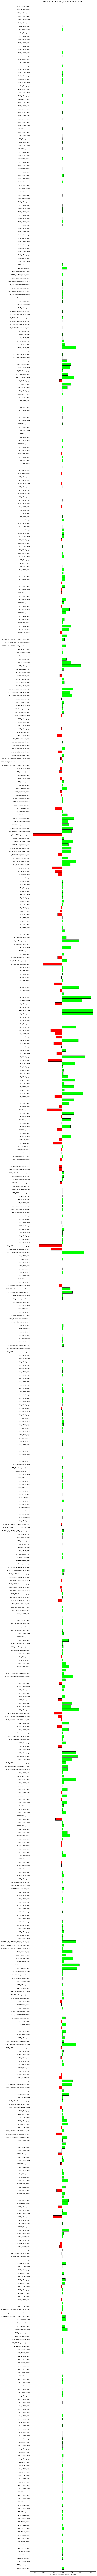

In [22]:
#list feature importances
fi = learn_14.feature_importance(feature_names=list(feature_names))

In [28]:
fi.head()


Feature  accuracy  accuracy_change
0                    RH_500mb_min  0.568500         0.016600
1                    RH_500mb_max  0.568625         0.016475
2                    RH_450mb_avg  0.569500         0.015600
3                    RH_700mb_avg  0.572750         0.012350
4  TMP_1829mabovemeansealevel_min  0.573525         0.011575

In [39]:
fi.shape

(775, 3)

In [40]:
fi = fi[fi['Feature'] != 'BASELINE']

In [41]:
fi_list = fi[fi['accuracy_change'] >= 0.0]['Feature'].values
fi_list.sort()
pd.Series(fi_list).to_csv(ml_path + 'fi_list_' + file_label + '_14days.csv', index=False)